In [ ]:
# 모두의 딥러닝

In [ ]:
# 20장 전이 학습을 통해 딥러닝의 성능 극대화하기

In [ ]:
# 20-1 소규모 데이터셋으로 만드는 강력한 학습 모델

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
! git clone https://github.com/taehojo/data-ch20.git

Cloning into 'data-ch20'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (265/265), done.
remote: Compressing objects: 100% (265/265), done.
remote: Total 265 (delta 0), reused 265 (delta 0), pack-reused 0
Receiving objects: 100% (265/265), 1.86 MiB | 2.04 MiB/s, done.


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

train_generator = train_datagen.flow_from_directory(
    'data-ch20/train',
    target_size=(150, 150),
    batch_size=5,
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'data-ch20/test',
    target_size=(150,150),
    batch_size=5,
    class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
#모델 실행의 옵션을 설정합니다. 
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

#모델을 실행합니다
history = model.fit(
       train_generator,
       epochs=100,
       validation_data=test_generator,
       validation_steps=10, 
       callbacks=[early_stopping_callback])

Epoch 1/100
32/32 [==============================] - 14s 38ms/step - loss: 0.6947 - accuracy: 0.5125 - val_loss: 0.6968 - val_accuracy: 0.3800
Epoch 2/100
32/32 [==============================] - 1s 33ms/step - loss: 0.6998 - accuracy: 0.4625 - val_loss: 0.6984 - val_accuracy: 0.3600
Epoch 3/100
32/32 [==============================] - 1s 35ms/step - loss: 0.6905 - accuracy: 0.5312 - val_loss: 0.6892 - val_accuracy: 0.4600
Epoch 4/100
32/32 [==============================] - 1s 35ms/step - loss: 0.6786 - accuracy: 0.6250 - val_loss: 0.6667 - val_accuracy: 0.6400
Epoch 5/100
32/32 [==============================] - 1s 34ms/step - loss: 0.6859 - accuracy: 0.5562 - val_loss: 0.6690 - val_accuracy: 0.6800
Epoch 6/100
32/32 [==============================] - 1s 36ms/step - loss: 0.6469 - accuracy: 0.7000 - val_loss: 0.6270 - val_accuracy: 0.6000
Epoch 7/100
32/32 [==============================] - 1s 33ms/step - loss: 0.6253 - accuracy: 0.6687 - val_loss: 0.5747 - val_accuracy: 0.7200
Epoch

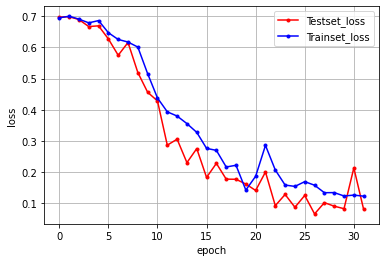

In [ ]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
# 20 -2 전이 학습으로 모델 성능 극대화하기

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 학습셋의 변형을 설정하는 부분입니다. 
train_datagen = ImageDataGenerator(rescale=1./255,          # 주어진 이미지의 크기를 설정합니다.
                                  horizontal_flip=True,     # 수평 대칭 이미지를 50% 확률로 만들어 추가합니다.
                                  width_shift_range=0.1,    # 전체 크기의 15% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1,   # 마찬가지로 위, 아래로 이동합니다.
                                  #rotation_range=5,        # 정해진 각도만큼 회전시킵니다.
                                  #shear_range=0.7,         # 좌표 하나를 고정시키고 나머지를 이동시킵니다.
                                  #zoom_range=1.2,          # 확대 또는 축소시킵니다.
                                  #vertical_flip=True,      # 수직 대칭 이미지를 만듭니다.
                                  #fill_mode='nearest'      # 빈 공간을 채우는 방법입니다. nearest 옵션은 가장 비슷한 색으로 채우게 됩니다.
                                  )      


train_generator = train_datagen.flow_from_directory(
       'data-ch20/train',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

# 테스트셋의 정규화를 설정합니다.
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       'data-ch20/test',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

# VGG16 모델을 불러옵니다.
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

# 우리의 모델을 설정합니다.
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1))
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 12

In [ ]:
# 모델의 실행 옵션을 설정합니다. 
finetune_model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다.
history = finetune_model.fit(
       train_generator,
       epochs=20,
       validation_data=test_generator,
       validation_steps=10, 
       callbacks=[early_stopping_callback])

Epoch 1/20
32/32 [==============================] - 3s 52ms/step - loss: 0.7584 - accuracy: 0.5437 - val_loss: 0.5537 - val_accuracy: 0.7000
Epoch 2/20
32/32 [==============================] - 1s 44ms/step - loss: 0.5525 - accuracy: 0.7312 - val_loss: 0.4792 - val_accuracy: 0.8800
Epoch 3/20
32/32 [==============================] - 1s 43ms/step - loss: 0.4774 - accuracy: 0.7750 - val_loss: 0.4306 - val_accuracy: 0.8600
Epoch 4/20
32/32 [==============================] - 1s 43ms/step - loss: 0.3847 - accuracy: 0.8562 - val_loss: 0.3741 - val_accuracy: 0.8200
Epoch 5/20
32/32 [==============================] - 1s 44ms/step - loss: 0.3622 - accuracy: 0.8625 - val_loss: 0.3294 - val_accuracy: 0.9000
Epoch 6/20
32/32 [==============================] - 1s 44ms/step - loss: 0.3314 - accuracy: 0.8875 - val_loss: 0.2699 - val_accuracy: 0.9400
Epoch 7/20
32/32 [==============================] - 1s 43ms/step - loss: 0.2840 - accuracy: 0.9187 - val_loss: 0.3101 - val_accuracy: 0.9000
Epoch 8/20
32

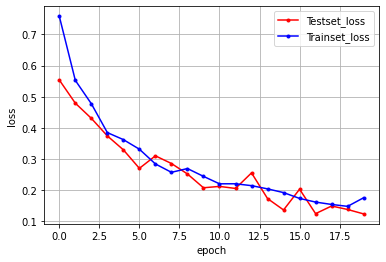

In [ ]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()